# LAB7 Assignment
> The document description are designed by JIa Yanhong in 2022. Oct. 20th
------

## LAB Assignment
### Exercise 1 logistic regression (20 points )
This exercise uses dataset digit01.csv , which has 13 columns, and the last column is the dependent variable. 

This part requires you to implement a `logistic regression` using the pytorch framework (defining a logistic regression class that inherits `nn.module`). To test your model, we provide a dataset `digit01.csv` which is in the **datasets folder**. This dataset requires you to divide the training set and the test set by yourself, and it is recommended that 80% of the training set and 20% of the test set be used.

+ load datasets

In [1]:
########### Write Your Code Here ###########
import pandas as pd
import numpy as np
df = pd.read_csv("./datasets/digit01.csv", header=None)
df.head()
############################################

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,1,1,1,0,1,1,0,1,1,1,1,0
1,0,1,1,1,0,1,1,0,1,1,1,1,0
2,1,1,0,1,0,1,1,0,1,1,1,1,0
3,1,1,1,1,0,1,1,0,1,1,1,0,0
4,1,1,1,1,0,1,1,0,1,0,1,1,0


+ Splitting dataset into 80% Training and 20% Testing Data:

In [3]:
########### Write Your Code Here ###########
X =df.iloc[:,:-1].values
y = df.iloc[:,-1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=112)
[i.shape for i in (X_train, X_test, y_train, y_test)]
############################################


[(51, 12), (13, 12), (51,), (13,)]

+ Define a LogisticRegression subclass of nn. Module

In [32]:
# Define a LogisticRegression subclass of nn. Module.
########### Write Your Code Here ###########
import torch
from torch import nn
class LogisticRegressionForBinaryClassification(nn.Module):
    """对数几率回归（不要翻译为逻辑回归，这没有任何逻辑）
    几率和概率的关系是 几率 l = p/(1-p)
    对数几率为 ln(l) = ln(p/(1-p)) = ln(p) - ln(1-p)
    使用线性回归预测对数几率，然后使用sigmoid函数将预测值转换为概率，这就是对数几率回归
    y = sigmoid(X @ W + b) <=> ln(y/(1-y)) = X @ W + b
    """
    def __init__(self, input_features):
        super().__init__() # 就应该这样写，写成super(LogisticRegressionForBinaryClassification， self)简直太傻了
        out_features = 1
        # xaviever = np.sqrt(2/(input_features+out_features))
        xaviever = 1
        self.W = nn.Parameter(torch.randn(input_features, out_features)
                                          *xaviever)
        self.b = nn.Parameter(torch.randn(1,out_features))
        # 这里我们尝试不用nn.Linear, 搞明白一般来说自己应该怎么定义可训练参数。
    def forward(self, X):
        # input shape: (batch_size, input_features)
        logits = X @ self.W + self.b # output shape: (batch_size, 1)
        out = torch.sigmoid(logits) # 1/(1+exp(-logits)) https://pytorch.org/docs/stable/special.html#torch.special.expit
        return out
############################################
test_X = torch.randn(10, 5)
test_model = LogisticRegressionForBinaryClassification(5)
test_y = test_model(test_X)
test_y

tensor([[0.2305],
        [0.8854],
        [0.9198],
        [0.7813],
        [0.7757],
        [0.6992],
        [0.8828],
        [0.0649],
        [0.9971],
        [0.5943]], grad_fn=<SigmoidBackward0>)

+ Create the model

In [68]:

########### Write Your Code Here ###########
lr4clf = LogisticRegressionForBinaryClassification(X_train.shape[1])
list(lr4clf.parameters())
############################################

[Parameter containing:
 tensor([[-0.3964],
         [-1.1124],
         [-1.2524],
         [ 1.0556],
         [-0.7752],
         [ 0.6146],
         [ 0.2815],
         [ 0.9958],
         [ 0.1683],
         [ 0.2903],
         [ 0.3655],
         [-1.1022]], requires_grad=True),
 Parameter containing:
 tensor([[-0.5736]], requires_grad=True)]

 + Loss function

In [46]:
########### Write Your Code Here ###########
from torch import optim
# criteria = nn.CrossEntropyLoss() # 不能用这个，这个的话网络的输出是logits。我们的网络的输出是概率
def cross_entropy_loss(y_pred, y_true, relax=1e-6):
    y_pred = torch.Tensor(y_pred)
    y_true = torch.Tensor(y_true)
    upper = 1+relax
    lower = 0-relax # 防止log(0)的出现
    return -torch.mean((y_true-lower)*torch.log(y_pred-lower) + (upper-y_true)*torch.log(upper-y_pred))
cross_entropy_loss(torch.tensor([1, 1, 1, 1, 1, 1]), torch.tensor([0, 0, 0, 0, 0, 0])) # 最大16左右
cross_entropy_loss(torch.zeros(6), torch.ones(6)) # 最大16左右
cross_entropy_loss(torch.zeros(6), torch.zeros(6)) 
############################################

tensor(1.2862e-05)

+ The optimizer

In [39]:
########### Write Your Code Here ###########
optimizer = optim.SGD(lr4clf.parameters(), lr=0.01)
############################################

+ training Model

In [40]:
########### Write Your Code Here ###########
def train(model, X, y, optimizer, criteria, epochs=201):
    model.train()
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criteria(y_pred, y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"epoch {epoch}, loss {loss.item()}")
train(lr4clf, X_train, y_train, optimizer, cross_entropy_loss)
############################################

epoch 0, loss 0.09115996956825256
epoch 10, loss 0.0907234475016594
epoch 20, loss 0.09029164165258408
epoch 30, loss 0.08986447751522064
epoch 40, loss 0.08944187313318253
epoch 50, loss 0.08902374655008316
epoch 60, loss 0.08861002326011658
epoch 70, loss 0.08820066601037979
epoch 80, loss 0.08779556304216385
epoch 90, loss 0.08739465475082397
epoch 100, loss 0.08699791878461838
epoch 110, loss 0.0866052433848381
epoch 120, loss 0.08621659129858017
epoch 130, loss 0.08583186566829681
epoch 140, loss 0.08545105159282684
epoch 150, loss 0.0850740522146225
epoch 160, loss 0.08470083028078079
epoch 170, loss 0.08433131873607635
epoch 180, loss 0.0839654728770256
epoch 190, loss 0.08360322564840317
epoch 200, loss 0.08324453234672546



+ Model Performance


In [121]:
########### Write Your Code Here ###########
def predict(model, X):
    model.eval()
    X = torch.tensor(X, dtype=torch.float32)
    y_pred = model(X)
    y_pred = y_pred.detach().numpy()
    # y_pred = np.where(y_pred>=0.5, 1, 0)
    y_predicted_cls = (y_pred>=0.5).astype(int)
    return y_predicted_cls
y_predicted_cls = predict(lr4clf, X_test)
cross_entropy_loss(torch.tensor(y_predicted_cls), torch.tensor(y_test))
############################################

tensor(5.4847)

In [45]:
y_predicted_cls

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [43]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted_cls))
# 可以看到效果非常好，达到100%的准确率

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         4

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



### Exercise 2  Handwriting recognition with MLP

Like last week's lab , your task in this section is also about recognizing handwritten digits, but you are required to use MLP to complete the exercise. It is recommended that you define an MLP class, which is a subclass of `nn.module`.

<font color='red' size=4>Note that your accuracy in this section will directly determine your score.</font>

For this exercise we use the `minist` dataset.

+ load datasets

In [112]:
########### Write Your Code Here ###########
import torchvision
from torch.utils.data import DataLoader
train_data, test_data = [torchvision.datasets.MNIST(
    root = './datasets/',  
    train = trainOrNot,       
    transform = torchvision.transforms.ToTensor(),   
    download=True
) for trainOrNot  in [True, False]]
train_loader, test_loader = [DataLoader(data, batch_size=64, shuffle=False) for data in [train_data, test_data]]
############################################                      

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


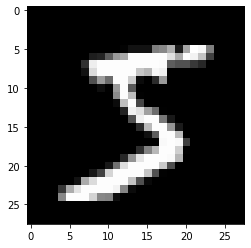

In [113]:
train_data.train_data
test_data.test_data
# train_data, test_data
trainfeature, trainlabel = next(iter(train_data))
from matplotlib import pyplot as plt
plt.imshow(trainfeature[0].detach().numpy(), cmap='gray')

+ Define a MLP subclass of nn. Module

In [114]:
########### Write Your Code Here ###########
class ReallyDeepMLP(nn.Module):
    def __init__(self, activation=nn.ReLU, hidden_node_sizes=None) -> None:
        super().__init__()
        if hidden_node_sizes is None:
            # hidden_node_sizes = [28*28, 1024, 256, 64, 10]
            hidden_node_sizes = [28*28, 64, 22, 13, 10]
        self.activation = activation
        # 我们这个网络支持任意层数的多层神经网络，用一个list来表示每一层的神经元个数。相应的，需要用ParameterList才能注册参数。
        self.linears = nn.ParameterList([nn.Linear(in_features, out_features) 
                                      for in_features, out_features in zip(hidden_node_sizes[:-1], hidden_node_sizes[1:])])
        self.flatten = nn.Flatten()
    def forward(self, X):
        X = self.flatten(X)
        for linear in self.linears[:-1]:
            X = torch.relu(linear(X))
        return self.linears[-1](X) # 最后一层不用激活函数，直接cross_entropy_loss。因为cross_entropy_loss里面有softmax
test_model = ReallyDeepMLP()
test_X = torch.randn(10, 28*28)
test_y = test_model(test_X)
test_y
############################################

tensor([[ 0.2347, -0.2535, -0.3155,  0.0843, -0.1590,  0.1375,  0.2274,  0.1979,
         -0.1230,  0.1594],
        [ 0.2375, -0.3108, -0.3668,  0.1065, -0.1305,  0.1542,  0.2015,  0.1471,
         -0.0958,  0.1124],
        [ 0.1209, -0.3409, -0.2823,  0.0520, -0.1866,  0.0528,  0.2372,  0.0809,
         -0.0352,  0.1563],
        [ 0.1633, -0.3794, -0.3197,  0.0956, -0.1390,  0.1259,  0.1826,  0.0922,
         -0.1125,  0.1522],
        [ 0.0788, -0.4464, -0.2902,  0.0934, -0.1627,  0.0669,  0.1956,  0.0625,
         -0.0669,  0.1661],
        [ 0.2842, -0.2772, -0.3504,  0.0665, -0.1561,  0.1556,  0.2184,  0.1977,
         -0.1480,  0.1304],
        [ 0.1462, -0.3369, -0.2970,  0.1090, -0.1633,  0.1068,  0.2013,  0.1462,
         -0.0869,  0.1710],
        [ 0.1611, -0.4155, -0.3169,  0.0451, -0.1436,  0.1354,  0.1356,  0.0740,
         -0.1662,  0.1722],
        [ 0.1410, -0.3352, -0.2905,  0.0796, -0.1588,  0.1143,  0.1849,  0.1326,
         -0.1284,  0.1845],
        [ 0.1417, -

+ Create the model

In [100]:
########### Write Your Code Here ###########
mlp_clf = ReallyDeepMLP()
mlp_clf
############################################

ReallyDeepMLP(
  (linears): ParameterList(
      (0): Object of type: Linear
      (1): Object of type: Linear
      (2): Object of type: Linear
      (3): Object of type: Linear
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=22, bias=True)
    (2): Linear(in_features=22, out_features=13, bias=True)
    (3): Linear(in_features=13, out_features=10, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

 + Loss function

In [101]:
########### Write Your Code Here ###########
criteria = nn.CrossEntropyLoss()
############################################

+ The optimizer

In [102]:
########### Write Your Code Here ###########
optimizer = optim.Adam(mlp_clf.parameters(), lr=0.01)
############################################

+ training Model

In [ ]:
########### Write Your Code Here ###########
def train_data_loader(model, data_loader, optimizer, criteria, epochs=101):
    model.train()
    for epoch in range(epochs):
        for X, y in data_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criteria(y_pred, y)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"epoch {epoch}, loss {loss.item()}")
train_data_loader(mlp_clf, train_loader, optimizer, criteria) #明智的选择是定义函数，而不是每次都写一遍
############################################
# 训练时间较长，后面我们存到了文件，可以直接加载

In [ ]:
# torch.save(mlp_clf.state_dict(), "net.pth")
# print("Saved PyTorch Model State to net.pth")

In [115]:
mlp_clf = ReallyDeepMLP() # 需要时同一个类型的model
mlp_clf.load_state_dict(torch.load("net.pth"))

<All keys matched successfully>

+ Model Performance

In [129]:
########### Write Your Code Here ###########
y_pred = mlp_clf(test_data.test_data.float())
criteria(mlp_clf(test_data.test_data.float()), torch.tensor(test_data.test_labels))
############################################

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\YeCanming\AppData\Local\Temp\ipykernel_31840\3005103853.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criteria(mlp_clf(test_data.test_data.float()), torch.tensor(test_data.test_labels))


tensor(69.0796, grad_fn=<NllLossBackward0>)

In [130]:
y_pred.shape
# y_pred[0]
# torch.argmax(y_pred, axis=1)

torch.Size([10000, 10])

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


ReallyDeepMLP accuracy = 0.9659
fper=[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10864745e-04
 1.10864745e-04 2.21729490e-04 2.21729490e-04 3.32594235e-04
 3.32594235e-04 4.43458980e-04 4.43458980e-04 5.54323725e-04
 5.54323725e-04 6.65188470e-04 6.65188470e-04 7.76053215e-04
 7.76053215e-04 8.86917960e-04 8.86917960e-04 9.97782705e-04
 9.97782705e-04 1.10864745e-03 1.10864745e-03 1.21951220e-03
 1.21951220e-03 1.44124169e-03 1.44124169e-03 1.66297118e-03
 1.66297118e-03 1.77383592e-03 1.77383592e-03 1.88470067e-03
 1.88470067e-03 2.10643016e-03 2.10643016e-03 2.54988914e-03
 2.54988914e-03 3.88026608e-03 3.88026608e-03 3.99113082e-03
 3.99113082e-03 4.10199557e-03 4.10199557e-03 4.54545455e-03
 4.54545455e-03 5.87583149e-03 5.87583149e-03 6.54101996e-03
 6.54101996e-03 7.64966741e-03 7.64966741e-03 9.20177384e-03
 9.20177384e-03 9.75609756e-03 9.75609756e-03 1.11973392e-02
 1.11973392e-02 1.31929047e-02 1.31929047e-02 2.16186253e-02
 2.16186253e-02 2.63858093e-02 2.63858093e-02 3.

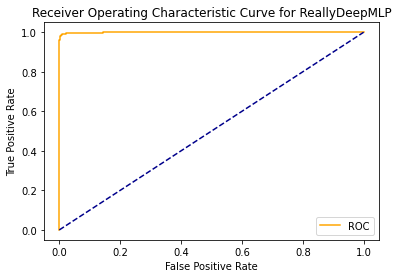

In [132]:
from fast_evaluation import *
evaluate_multiclass2(mlp_clf, y_pred.detach().numpy(), test_data.test_labels.detach().numpy())
# 可见，测试集准确率达到96.59%。对0的分类的ROC曲线可以画出来：

### Exercise 3  Questions (10 points )
1.What's the difference between logistic regression and Perceptron?

（1）Perceptron对分类正确的数据不会学习，只去学习分类错误的数据，而logistic regression对所有的数据都会学习。

（2）Perceptron的输出是0或1，而logistic regression的输出是0到1之间的实数。logistic regression的输出可以看作是一个概率值，表示属于某一类的概率。

（3）Perceptron的理论依据是生物神经元；而logistic regression的理论依据更加坚实，可以用贝叶斯框架去解释。具体来说，logistic function 是 假设了数据服从伯努利分布，然后用极大似然估计去估计参数。而且，logistic是可导的，有坚实的优化理论支撑，可以用梯度+优化器去优化，但是Perceptron就是从生物那里仿生过来的，说“Perceptron learning rule”，数学基础弱一些。

2.Advantages and disadvantages of neural networks?

 神经网络的优点是可以自动学习特征，不需要人工去提取特征，而且可以自动学习特征的组合，从而可以自动学习出复杂的特征。神经网络的缺点是需要大量的训练数据，而且训练时间比较长。

3.What is the role of Activation Function in Neural networks?
神经网络是线性的，但是数据不一定线性可分，所以需要引入非线性的激活函数，使得神经网络可以拟合非线性的数据，这是一方面。


### Exercise 4 获取认证：使用MindSpore训练手写数字识别模型

访问以下网址，
https://www.hiascend.com/edu/certification/detail/c6896776040f409fa8dcd233691ef800
获得认证，截图并提交。
![截图](./.assets/认证.png)
![截图](./.assets/记录.png)